In [15]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy as sp
import os,csv
import statsmodels.api as sm
from scipy import interpolate
import sys
sys.path.append("..")

# === Matplotlib ===
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams


# === Import Maksim's functions === 
# Module in the same directory MD_Capacitance.py
import MD_potential
from MD_potential import *
import MD_capacitance
from MD_capacitance import *

# === Logging ===
import logging
logging.basicConfig()
log=logging.getLogger('ipynb')
log.setLevel(logging.DEBUG)
log.info('logging initialized')

# === Import defined parameters for plotting ===
# Module in the same directory graph_parameters.py
import graph_parameters
from graph_parameters import *
#from graph_parameters import savitzky_golay


# === Import constants ===
# Module in the same directory constants.py
import constants

INFO:ipynb:logging initialized
INFO:ipynb:logging initialized


In [2]:
k = 1.9872041E-3  # kcal/mol/K
rho = 0.03332819694513222
el_chg = 1.60217662e-19 #coulomb
Na = 6.02214129e23
epsilon0 =  8.854187817e-12  #F/m
eps0 = 5.5268e-2  # e/V/nm
kcal_eV = 2.611448e22  # kcal/(eV)

# Functions for potential calculation

In [3]:
def find_array_minimum_point(z_coord, array, z_min, z_max):
    """ 
    Find the smallest absolute value of array within given range, 
    """
    from scipy import interpolate
    midpoint = 0.5*(z_min+z_max)
    # create interpolation function for array
    array_itp = interpolate.interp1d(z_coord, array, kind='linear')
    # return absolute value of the interpolated function
    abs_array_itp = lambda z_coord : abs(array_itp(z_coord)[0])
    bounds = [(z_min, z_max)]
    # minimize absolute value of the array, subject to bounds
    x = sp.optimize.minimize(abs_array_itp, midpoint, bounds=bounds)
    return x.x[0]


def lpot_rpot(z_coord, pot, z_mid1=4, z_mid2=6, field=None, z_end=None, debug=False):
    """ Return potential drops on left and right electrodes, given coordinates and potential.
    If field is provided, defines midpoint as a place where field is closest to 0 within z_mid1, z_mid2 range.
    
    In debug mode in addition to two potentials, returns the location of minimum field.
    """
    if not z_end:
        z_end = z_coord[-1]
    if np.any(field):
        smallest_field = find_array_minimum_point(field[:,0], field[:,1], z_mid1, z_mid2)
        # evaluate potential in the region +/- 2*dz from the smallest field location
        dz = z_coord[1] - z_coord[0]
        mask = (z_coord > smallest_field - 2*dz) & (z_coord < smallest_field + 2*dz)
        mid_pot = np.mean(pot[mask])
    else:
        mask = (z_coord > z_mid1) & (z_coord < z_mid2)
        mid_pot = np.mean(pot[mask])
    end_pot = np.mean(pot[z_coord > z_end])
    if debug:
        return mid_pot, end_pot - mid_pot, smallest_field
    else:
        return mid_pot, end_pot - mid_pot

    
class ChgSimulation(object):
    """A utility object used to describe a series of simulations at a certain surface charge."""
    eps0 = 5.5268e-2
    chg_eps = 1.0e-6 # level for non-zero charge
    
    def __init__(self, chg_sim_dir, chg_name='charge.xvg', replicas=None, field_name=None, 
                 pot_name=None, log=None, walls=None, set_chg=False, eps_rf=1):
        """
        chg_sim_dir : string
            directory in which simulations with a constant surface charge are located. The final part of
            the path must include surface charge value for simulations. For example: my/long/path/3.0
            
        chg_name : string, default charge.xvg
            the name of the files containing charge distribution in simulation box
        
        replicas : list-like, default None
            names of directories in chg_sim_dir (without full_path), containing individual simulations.
            If None is provided, will analyze all directories in chg_sim_dir.
            
        field_name : string, default None
            the name of the files containing field distribution in simulation box. If none, will be
            computed from the charge distribution
            
        pot_name : string, default None
            the name of the files containing potential distribution in simulation box. If none, will be
            computed from the charge distribution
            
        walls : array or string, default None
            location of left and right wall (electrodes). If none - will try to guess it using charge distribution
            If walls=='edges', assumes that walls are located at the edges of provided z-coordinates
        
        set_chg : Float, default False
            Set surface charge to walls
            
        eps_rf : float, default 1
            Dielectric constant throught the box. Used to downscale walls
            
        log : object, default None
            an object of python logging module
        """
        # init stuff
        if log:
            self.log = log
        else:
            self.log = logging.getLogger(name='charge simulation logger')
            self.log.setLevel(logging.INFO)
        self.chg_sim_dir = chg_sim_dir
        self.chg_name = chg_name
        if not replicas:
            replicas = [d for d in os.path.listdir(chg_sim_dir) if os.path.isdir(os.path.join(chg_sim_dir, d))]
        self.replicas = [os.path.join(chg_sim_dir, replica) for replica in replicas]
        self.field_name = field_name
        self.pot_name = pot_name
        if chg_sim_dir.endswith('/'):
            chg_sim_dir = chg_sim_dir[:-1]
        self.surf_chg = float(os.path.split(chg_sim_dir)[1])
        self.eps_rf = eps_rf
        self.no_field_points = []  # locations near the center of the box where field is close to 0
        self.chgs   = []  # charge distributions
        self._get_chgs()
        self.dz = self.chgs[0][1,0] - self.chgs[0][0,0] # step between grid points
        if walls=='edges':
            # leave a bit of space
            self.lelec = [self.dz]*len(replicas)
            self.relec = [self.chgs[i][-2,0] for i in range(len(replicas))]
        elif walls:
            self.lelec = [walls[0]]*len(replicas)
            self.relec = [walls[1]]*len(replicas)
        else:
            self.lelec = []  # locations of left electrode
            self.relec = []  # locations of left electrode
            self._find_walls()
        if set_chg:
            self._set_wall_charge()
        self.fields = []  # field distributions
        self._get_fields()
        self._find_midpoints()
        self.inbetween_fields = [] # the field strengths in the regions between electrode and IL
        #self._compute_inbetween_fields()
        
    def _get_chgs(self):
        """Load charges from replicas"""
        for replica in self.replicas:
            self.log.debug('Finding walls for replica: {}'.format(replica))
            chg = np.loadtxt(os.path.join(replica, self.chg_name), comments=['#','@'])
            self.chgs.append(chg)
                
    def _find_walls(self):
        """find positions of left and right elctrode in each replica using the locations of the 
        first points, where charge is non-zero. To deal with chg=0 we add an offset of 10*dz
        """
        for i, chg in enumerate(self.chgs):
            self.log.debug('Finding walls for replica: {}'.format(self.replicas[i]))
            dz = chg[1,0]-chg[0,0]
            non_zero_chg = np.abs(chg[:,1]) > self.chg_eps
            self.lelec.append(chg[:,0][non_zero_chg][0])
            self.relec.append(chg[:,0][non_zero_chg][-1])
            if abs(self.surf_chg) < 1.0e-3:
                self.lelec[-1] = self.lelec[-1] - 10*dz
                self.relec[-1] = self.relec[-1] + 10*dz
            self.log.debug('Left wall found at: {}'.format(self.lelec[-1]))
            self.log.debug('Right wall found at: {}'.format(self.relec[-1]))
            
    def _set_wall_charge(self):
        microC_per_cm2_to_electron_per_nm2_conv = 0.062415091
        chg_density = self.surf_chg*microC_per_cm2_to_electron_per_nm2_conv/self.dz
        for i, (lelec, relec) in enumerate(zip(self.lelec, self.relec)):
            left_wall_mask = np.isclose(self.chgs[i][:,0], lelec, atol=self.dz/2)
            right_wall_mask = np.isclose(self.chgs[i][:,0], relec, atol=self.dz/2)
            assert sum(left_wall_mask) == 1
            assert sum(right_wall_mask) == 1
            self.chgs[i][:,1][left_wall_mask] =   chg_density/self.eps_rf
            self.chgs[i][:,1][right_wall_mask] = -chg_density/self.eps_rf

    def _get_fields(self):
        """load/computed field distributions in the boxes"""
        if self.field_name:
            for replica in self.replicas:
                self.fields.append(np.loadtxt(os.path.join(replica, self.field_name), comments=['#','@']))
        else:
            # compute field ourselves
            for chg in self.chgs:
                field_f = interpolate.InterpolatedUnivariateSpline(chg[:,0], chg[:,1], k=1).antiderivative()
                self.fields.append(np.c_[chg[:,0], field_f(chg[:,0])/ChgSimulation.eps0/self.eps_rf])
        
    def _find_midpoints(self):
        """find positions within +/- 1 [in provided length units] from the middle of the box, 
        where the field is smallest
        """
        for i, replica in enumerate(self.replicas):
            mid = 0.5*(self.lelec[i] + self.relec[i])
            self.log.debug("mid point: {}".format(mid))
            # create interpolation function for array
            array_itp = interpolate.interp1d(self.fields[i][:,0], self.fields[i][:,1], kind='linear')
            # return absolute value of the interpolated function
            abs_array_itp = lambda z_coord : abs(array_itp(z_coord)[0])
            bounds = [(mid-1, mid+1)]  # +/- 1 from mid in sim units
            self.log.debug("wall bounds {}".format(bounds))
            # minimize absolute value of the array, subject to bounds
            x = sp.optimize.minimize(abs_array_itp, mid, bounds=bounds)
            self.no_field_points.append(x.x[0])
            
    def _compute_inbetween_fields(self):
        """find the strength of the field between electrode and IL.
        Assumes it is equal to the strength of the field immediately (10*dz) after the location of electrode wall.
        Does this for both left and right electrode and throws error if they are not very similar for
        any of the replicas
        """
        for i, field in enumerate(self.fields):
            lfield = np.mean(field[:,1][np.isclose(field[:,0], self.lelec[i] + 2*self.dz, atol=self.dz)])
            rfield = np.mean(field[:,1][np.isclose(field[:,0], self.relec[i] - 2*self.dz, atol=self.dz)])
            
            if not np.isclose(lfield, rfield, atol=.1, rtol=1.0e-2):
                plt.plot(field[:,0], field[:,1])
                plt.plot(self.chgs[i][:,0], self.chgs[i][:,1])
                plt.hlines(lfield, self.lelec[i], self.relec[i], 'red', linestyles='--')
                plt.hlines(rfield, self.lelec[i], self.relec[i], 'green', linestyles='--')
                plt.xlim(self.lelec[i] - 15*self.dz, self.lelec[i] + 15*self.dz)
                plt.vlines([self.lelec[i] + 3*self.dz,  self.relec[i] - 3*self.dz], field[:,1].min(), field[:,1].max())
                self.log.debug('dz: {}'.format(self.dz))
                plt.show()
                plt.plot(field[:,0], field[:,1])
                plt.plot(self.chgs[i][:,0], self.chgs[i][:,1])
                plt.hlines(lfield, self.lelec[i], self.relec[i], 'red', linestyles='--')
                plt.hlines(rfield, self.lelec[i], self.relec[i], 'green', linestyles='--')
                plt.xlim(self.relec[i] - 15*self.dz, self.relec[i] + 15*self.dz)
                plt.vlines([self.lelec[i] + 3*self.dz,  self.relec[i] - 3*self.dz], field[:,1].min(), field[:,1].max())
                plt.show()
                raise ValueError("Left {} and right {} in-between fields are too different!".format(lfield, rfield))
            self.inbetween_fields.append(lfield)
            
    def get_lpots(self, rel_pos=0):
        """ Get potential drops on left electrode.
        
        rel_pos : float, default = 0
            Adjust electrode charge plane relative to the original wall positions. Positive values
            correspond to position closer to the IL, negative - further away from it
        """
        pots = []
        for i, field in enumerate(self.fields):
            z, field_vals = field[:,0], field[:,1]
            chg_pos = self.lelec[i] + rel_pos
            # if chg_pos is more to the left relative to real wall, use in-between field
            # oterwise simply compute potential
            if chg_pos < self.lelec[i]:
                field_vals = np.copy(field_vals)
                field_vals[(z >= chg_pos) & (z < self.lelec[i])] = self.inbetween_fields[i]
            pot_mask = (z >= chg_pos) & (z < self.no_field_points[i])
            pots.append(-np.sum(field_vals[pot_mask])*self.dz)
        return np.asarray(pots)
    
    def get_rpots(self, rel_pos=0):
        """ Get potential drop on right electrode.

        rel_pos : float, default = 0
            Adjust electrode charge plane relative to the original wall positions. Positive values
            correspond to position closer to the IL, negative - further away from it
        """
        pots = []
        for i, field in enumerate(self.fields):
            z, field_vals = field[:,0], field[:,1]
            chg_pos = self.relec[i] - rel_pos
            # if chg_pos is more to the right relative to real wall, use in-between field
            # oterwise simply compute potential
            if chg_pos > self.relec[i]:
                field_vals = np.copy(field_vals)
                field_vals[(z <= chg_pos) & (z > self.relec[i])] = self.inbetween_fields[i]
            pot_mask = (z <= chg_pos) & (z > self.no_field_points[i])
            pots.append(np.sum(field_vals[pot_mask])*self.dz)
        return np.asarray(pots)
    
    def get_pot_distribs(self, i=0):
        """ get potential distribution for i-th replica"""
        if self.pot_name:
            pot = np.loadtxt(os.path.join(self.replicas[i], self.pot_name), comments=['#','@'])
        else:
            pot_f = interpolate.InterpolatedUnivariateSpline(self.fields[i][:,0], 
                                                             self.fields[i][:,1], k=1).antiderivative()
            pot = np.c_[self.fields[i][:,0], -pot_f(self.fields[i][:,0])]
        return pot

    def plot(self, rel_pos=0, xlim=None):
        """ Plot what is going on for debug purposes."""
        lpots = self.get_lpots(rel_pos)
        rpots = self.get_rpots(rel_pos)
        fig, (ax1,ax2)  = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(len(self.replicas)):
            # left figure
            z, field = self.fields[i][:,0], self.fields[i][:,1]
            field_at_nofield_point = field[np.argmin(z - self.no_field_points[i])]
            ax1.plot(z, field)
            ax1.plot(self.no_field_points[i], field_at_nofield_point, 'ro')
            pot = self.get_pot_distribs(i)[:,1]
            # right figure
            ax2.plot(z, pot)
            ax2.hlines([lpots[i]], 0, self.relec[i], 'b')
            ax2.hlines([lpots[i] - rpots[i]], 0, self.relec[i], 'c')
            # both figures
            ax1.vlines([self.lelec[i], self.relec[i]], min(field), max(field), 'red', '--')
            ax2.vlines([self.lelec[i], self.relec[i]], min(pot), max(pot), 'red', '--')
            if xlim:
                ax1.set_xlim(*xlim)
                ax2.set_xlim(*xlim)
        ax1.set_title('field'); ax2.set_title('potential')
    
    
def mod_z_score(vals):
    """Computes modified z-score to test for outliers. Outliers are points with m-z score > 3.5
    http://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
    """
    vals = np.asarray(vals)
    mad = np.median(np.absolute(vals - np.median(vals)))
    return np.abs(.6745*(vals - np.median(vals))/mad)

def compute_potentials(simulations, rel_pos=0, exclude_outliers=True, find_average=True):
    chgs = np.asarray([sim.surf_chg if sim else np.NaN for sim in simulations])
    chgs = np.hstack([-chgs[::-1], chgs])
    potentials = []
    for sim in simulations:    
        if sim:
            lpots = sim.get_lpots(rel_pos)
            rpots = sim.get_rpots(rel_pos)
            if exclude_outliers and np.any(mod_z_score(lpots) > 3.5):
                log_string = 'Left electrode in simulation {} contains possibly outlying potential '
                log_string += ', '.join('{:.3f}({:.1f})'.format(*vals) for vals in zip(lpots, mod_z_score(lpots)))
                log_string += '. Ignoring potentials with z-score > 3.5.'
                log.debug(log_string)
                lpots = lpots[mod_z_score(lpots) <= 3.5]
            if exclude_outliers and np.any(mod_z_score(rpots) > 3.5):
                log_string = 'Right electrode in simulation {} contains possibly outlying potential '
                log_string += ', '.join('{:.2f}({:.1f})'.format(*vals) for vals in zip(rpots, mod_z_score(rpots)))
                log_string += '. Ignoring potentials with z-score > 3.5.'
                log.debug(log_string)
                rpots = rpots[mod_z_score(rpots) <= 3.5]
            if find_average:
                potentials.append([np.nanmean(lpots), np.nanmean(rpots)])
            else:
                potentials.append([lpots, rpots])
        else:
            potentials.append([np.NaN, np.NaN])
            
    potentials = np.asarray(potentials)
    averaged_potentials = np.hstack([-potentials[:,1][::-1], -potentials[:,0]])
    #return averaged_potentials

    # get rid of NaN-s
    chgs = chgs[np.logical_not(np.isnan(averaged_potentials))]
    averaged_potentials = averaged_potentials[np.logical_not(np.isnan(averaged_potentials))]

    gromacs_data = np.c_[averaged_potentials, chgs]
    
    return gromacs_data

/home/prace/opt/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


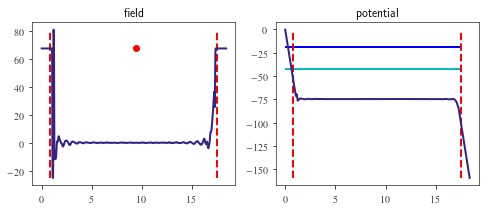

In [4]:
chsim1 = ChgSimulation('/data/Julia/AuBMImPF6/Experiments/A3/BMImPF6/450/a/60.00', chg_name='charge.xvg',
                       pot_name='potential_mod.xvg', field_name='field_mod.xvg', replicas=['3'], walls=[0.825, 17.499])#, set_chg=True)

chsim1.plot() #xlim=(15,18)

# Load potentials

/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:293: RuntimeWarning: invalid value encountered in divide


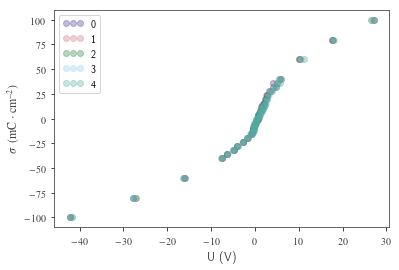

In [5]:
# directory containing base directories for simulations with different electrode surface charges
base_path = '/data/Julia/AuBMImPF6/Experiments/A3/BMImPF6/450/a'

# surface charges to analyze
surf_chgs = [dirs for dirs in os.listdir(base_path) 
              if os.path.isdir(os.path.join(base_path, dirs)) and '.' in dirs]
surf_chgs = sorted(surf_chgs, key=float)

replicas = ['0','1','2','3','4']              # which replicas to analyze for each charge
for r in replicas:
    chg_name='charge.xvg'                   # the name of text file containign values of charge depending on z
    generic_data_path = base_path + '/{surf_chg}'  # should reflect directory structure
    # optional
    pot_name = 'potential_mod.xvg'              # the name of text file containign values of potential depending on z
    field_name = 'field_mod.xvg'                # the name of text file containign values of field depending on z
    walls=None
    #A3 0.825 17.499 0.118
    walls = (0.825+0.118, 17.499-0.118)         #0.072 is a half space between Au-Au layers
    set_chg = False  # x-y dimensions in nm
    debug = True  # extra printing and plotting
    if debug:
        log.setLevel(level=logging.DEBUG)

    simulations = []
    for surf_chg in surf_chgs:
        p = generic_data_path.format(surf_chg=surf_chg)
        try:
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=r, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, set_chg=set_chg)
            simulations.append(chsim)
            #print surf_chg
            #chsim.plot()
        except IOError:
            log.info('Simulations for surf_chg = {} were not found!, skipping!'.format(surf_chg))
        except Exception as e:
            log.exception(e)
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=replicas, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, log=log)
    pots = compute_potentials(simulations, exclude_outliers=True)
    plt.plot(pots[:,0], pots[:,1], 'o', alpha=0.3, label=str(r))
plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
plt.legend(loc='best')

Check that potential looks ok and that there are no outliers

# Capacitance calculations

## Capacitance functions

In [6]:
def conv_smooth(x, y, window_size=11, window='hanning', extension=100):
    """ Convolve signal with hanning window"""
    # extend function to makes sure edges behave nicely
    dx = x[1] - x[0]
    x_itp_long = np.arange(x.min() - extension, x.max() + extension, dx)
    y_itp_long_f = sp.interpolate.InterpolatedUnivariateSpline(x, y, k=1)
    y_itp_long = y_itp_long_f(x_itp_long)
    # after convolution part of the function close to the edges behave poorly
    # so we cut them
    l_cut = (window_size - 1)/2
    r_cut = window_size - 1 - l_cut
    # convolution magic from
    # http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    s = np.r_[y_itp_long[window_size-1:0:-1], y_itp_long, y_itp_long[-1:-window_size:-1]]
    w = eval('np.' + window + '(window_size)')
    y_smooth = np.convolve(w/w.sum(), s, mode='valid')[l_cut:-r_cut]
    # return to non-extended function
    return y_smooth[(x_itp_long > x[0]-dx/2.0) & (x_itp_long < x[-1]+dx/2.0)]


def num_derivC(pot, chg):
    """ Central difference numerical deriv using numpy."""
    dchg = np.gradient(chg)
    dpot = np.gradient(pot)
    return dchg/dpot

def plot_window(ax, x, window_size, window, plot_size=.1):
    w = eval('np.' + window + '(window_size)')
    dx = x[1]-x[0]
    x_plot = np.arange(0, window_size*dx - dx*.1, dx)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    func = w*(y_max - y_min)*plot_size + y_min
    ax.plot(x_plot + x_max - x_plot[-1], func, 'k-')
    
def compute_cap(gromacs_data, itp_points=1000, w='hamming', fine_ws=61, coarse_ws=201, chg_left=-20,
                chg_right=20):
    # interpolate to increase point size
    # and regularize grid
    pot, chg = gromacs_data[:,0], gromacs_data[:, 1]
    chg_itp = np.linspace(chg.min(),chg.max(), itp_points)
    pot_itp_f = interpolate.interp1d(chg, pot, kind='linear')
    pot_itp = pot_itp_f(chg_itp)

    # Convolution - smoothing
    # convolve with hamming window
    # optimally, we want to describe low surface charges with less (fine) smoothing (since we have a lot of simulations there)
    # and smooth pot-chg relation for higher charges to larger extent (coarse smoothing)

    # transition speeeds from coarse to fine and from fine to coarse smoothings
    trans_left = 5.0
    trans_right = 5.0

    # smoothed pots
    fine_pot = conv_smooth(chg_itp, pot_itp, fine_ws, window=w)
    coarse_pot = conv_smooth(chg_itp, pot_itp, coarse_ws, window=w)

    # merge two potentials at two different points
    sigma1 =  1. / (1 + np.exp(-(chg_itp - chg_left) / trans_left));
    sigma2 =  1. / (1 + np.exp(-(chg_itp - chg_right) / trans_right));
    merged = (1-sigma1) * coarse_pot + sigma1 * fine_pot
    merged = (1-sigma2) * merged + sigma2 * coarse_pot
    
    cap = num_derivC(merged, chg_itp)
    return np.c_[chg_itp, merged, cap]

def plot_cap(gromacs_data, rel_pos=0, itp_points=1000, w='hamming', fine_ws=151, coarse_ws=201, chg_left=-20,
             chg_right=20):
    chg_pot_cap = compute_cap(gromacs_data, itp_points=itp_points, w=w, fine_ws=fine_ws,
                              coarse_ws=coarse_ws, chg_left=chg_left, chg_right=chg_right)
    pot, chg = gromacs_data[:,0], gromacs_data[:,1]
    chg_itp, conv_pot, cap = chg_pot_cap[:,0], chg_pot_cap[:,1], chg_pot_cap[:,2]
    #plt.plot(pot_itp, chg_itp , label='itp', alpha=.5)
    fine_ws=61; coarse_ws=20
    fig, (ax1,ax2)  = plt.subplots(ncols=2, figsize=(9, 4))
    ax1.plot(conv_pot, chg_itp, '-', label='conv')#, lw=3)
    ax1.plot(pot, chg, '.', c='red', label='data')
    ax1.set_xlabel('U (V)')
    ax1.set_ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
    ax1.legend(loc='best')
    ax1.set_xlim(pot.min(), pot.max())
    ax1.set_ylim(chg.min(), chg.max())
    ax2.plot(chg_pot_cap[:,1],chg_pot_cap[:,2],  label='fit')
    ax2.legend(loc='best')
    ax2.set_xlabel('U (V)')
    ax2.set_ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
    #plt.savefig('../gfx/u_pot.png',dpi=300)

    print 'Capacitance maximum: {}'.format(np.amax(chg_pot_cap[:,2]))
    print 'Corresponding charge: {}'.format(chg_pot_cap[:,0][np.argmax(chg_pot_cap[:,2])])
    print 'Corresponding potential: {}'.format(chg_pot_cap[:,1][np.argmax(chg_pot_cap[:,2])])
    return fig, (ax1, ax2)


### Smoothing pot/chg

Capacitance maximum: 9.17165948693
Corresponding charge: 3.5035035035
Corresponding potential: 0.967115784462


/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:293: RuntimeWarning: invalid value encountered in divide


(0, 20)

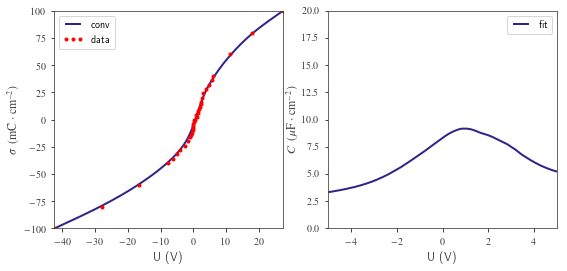

In [7]:
fig, (ax1,ax2) =plot_cap(compute_potentials(simulations, rel_pos=0.0), fine_ws=261)
ax2.set_xlim(-5,5)
ax2.set_ylim(0,20)

Capacitance maximum: 10.1017703861
Corresponding charge: -4.5045045045
Corresponding potential: 0.0989551541324


/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:293: RuntimeWarning: invalid value encountered in divide


(-2, 2)

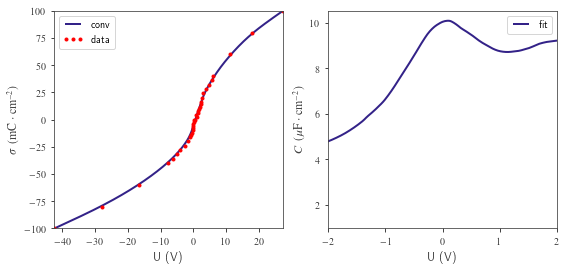

In [8]:
fig, (ax1, ax2) = plot_cap(compute_potentials(simulations, rel_pos=.0), fine_ws=161)
ax2.set_xlim(-2, 2)
#ax2.set_ylim(0,100)


In [9]:
chg_pot_cap = compute_cap(compute_potentials(simulations, rel_pos=.087),itp_points=1000, w='hamming', 
                          fine_ws=61, coarse_ws=151, chg_left=-20, chg_right=20)

np.savetxt('/home/prace/Bi_emimI_chg_pot_cap.txt', chg_pot_cap)

/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:293: RuntimeWarning: invalid value encountered in divide


In [10]:
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML

In [11]:
def func(**kwargs):
    plot_cap(compute_potentials(**kwargs))

interactive(func, simulations=fixed(simulations), rel_pos=(-.5, .5, .01))


interactive(children=(FloatSlider(value=0.0, description=u'rel_pos', max=0.5, min=-0.5, step=0.01), Output()), _dom_classes=('widget-interact',))

# Fit function

### fitting cation

In [12]:
U0 = .15        # V
U_max_c = -1.27877117e+01
theta_max_c = 40


def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]


def fit_c(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains: U_max_c (V), gamma_c, a0_c
    """
    gamma_c, a0_c = x
    u = (U - U0)/U_max_c
    sigma_fit_c = sigma_fit(u, theta_max_c, gamma_c, a0_c)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_c, gamma_c, a0_c)+theta_max_c))+1)
    return np.sum(np.abs(sigma-sigma_fit_c)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_c_fit = chg_itp[chg_itp < -30]
U_c_fit = conv_pot[chg_itp < -30]


# initial guess
# gamma, a0
x0 = [  2.02, 0.62]

res = sp.optimize.minimize(fit_c, x0, args=(sigma_c_fit, U_c_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
#x  = res.x
x = res.x

u = (U_c_fit-U0)/U_max_c
plt.plot(U_c_fit, sigma_c_fit,'-o', label='data')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x[0], x[1]), '-', label='fit')
plt.plot(U_c_fit, sigma_fit(u, theta_max_c, x0[0], x0[1]), '--', label='fit0')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

NameError: name 'chg_itp' is not defined

In [13]:
U0 = .15          # V
U_max_a =  8.64749511e+00
theta_max_a = -16  # microC/cm^2

def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]


def fit_a(x, sigma, U):
    """
    Cation fit objective function
    
    x : list
        Contains:  gamma_a, a0_a
    """
    gamma_a, a0_a = x
    u = (U - U0)/U_max_a
    sigma_fit_a = sigma_fit(u, theta_max_a, gamma_a, a0_a)
    inv_dist_from_kappa = 1./(np.sqrt(np.abs(sigma_fit(u, theta_max_a, gamma_a, a0_a)+theta_max_a))+1)
    return np.sum(np.abs(sigma-sigma_fit_a)**(2)*inv_dist_from_kappa)


# Define fit region
# sigma_c_fit = gromacs_data[:,1][gromacs_data[:,1] > 30]
# U_c_fit = gromacs_data[:,0][gromacs_data[:,1] > 30]
sigma_a_fit = chg_itp[chg_itp > 10]
U_a_fit = pot_itp[chg_itp > 10]


# initial guess
# gamma, a0
x0 = [  2, 0.7]

res = sp.optimize.minimize(fit_a, x0, args=(sigma_a_fit, U_a_fit), bounds=[(0,100000), (0.5, 1)],
                          options={'ftol' : np.finfo(float).eps})
print res
#x  = res.x
x = res.x

u = (U_a_fit-U0)/U_max_a
plt.plot(U_a_fit, sigma_a_fit,'-o', label='data')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x[0], x[1]), '-', label='fit')
plt.plot(U_a_fit, sigma_fit(u, theta_max_a, x0[0], x0[1]), '--', label='fit0')

plt.xlabel('sigma microC/cm2')
plt.ylabel('U V')
plt.legend(loc='best')

NameError: name 'chg_itp' is not defined

/home/prace/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


NameError: name 'conv_pot' is not defined

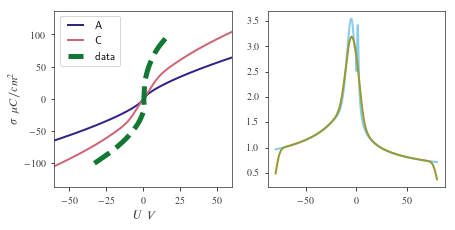

In [14]:
def sigma_fit(u, theta_max, gamma, a0):
    exponential_term  = a0 + (1 - a0)*np.exp(-gamma*u**2)
    return np.r_[(theta_max*(-u)**(exponential_term))[u<0],-(theta_max*u**(exponential_term))[u>=0]]



# data
U0 = .15          # V
U_max_a =  8.64749511e+00
U_max_c =  1.27877117e+01
theta_max_a = -16  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
gamma_c = 1.90891538
a0_c = 0.61969294
gamma_a = 43.52760518
a0_a = 0.71859516

# individual capacitances
#U_fit = np.linspace(-80, 40, num=1000)
U_fit, dU = np.linspace(-80, 80, num=1000, retstep=True)
u_a = (U_fit-U0)/U_max_a
u_c = (U_fit-U0)/U_max_c

sigma_a = sigma_fit(u_a, theta_max_a, gamma_a, a0_a)
sigma_c = -sigma_fit(u_c, theta_max_c, gamma_c, a0_c)
C_a = np.gradient(sigma_a, dU)
C_c = np.gradient(sigma_c, dU)

# combination of capacitances
gamma_ac = (max(gamma_c, gamma_a)/min(gamma_c, gamma_a))**(1./2)
C_h = 0.5*(C_a+C_c)+ 0.5*(np.tanh(gamma_ac*u_a)*C_a-np.tanh(gamma_ac*u_c)*C_c)

# smoothing
window = sp.signal.gaussian(400, 20)
# convolve the arrays
sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(7,3.25))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(chg_pot_cap[:,1],chg_pot_cap[:,0],'--',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-60,60)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

#ax2.plot(U_fit, C_a, label='C-a',alpha=.3)
#ax2.plot(U_fit, C_c, label='C-c', alpha=.3)
ax2.plot(U_fit, C_h, label='C', color=color_wheel[3])
ax2.plot(U_fit, sC_h, label='C sm', color=color_wheel[5])
ax2.plot(conv_pot,chg_pot_cap[:,2], '--',lw=5,  label='data',color=color_wheel[2])

ax2.set_xlim(-15, 15)
ax2.set_xlabel('$U$ $V$')
ax2.set_ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
ax2.locator_params(axis = 'x',nbins=5)

ax2.legend(loc='best', fontsize=11)

fig.tight_layout()
#fig.savefig('../gfx/estimated_cap.png',dpi=300)

In [ ]:
fig, (ax1) = plt.subplots(ncols=1,figsize=(7,7))

ax1.plot(U_fit, sigma_a, label='A')
ax1.plot(U_fit, sigma_c, label='C')
ax1.plot(gromacs_data[:,0],gromacs_data[:,1],'o',label='data',lw=5)
ax1.set_xlabel('$U$ $V$')
ax1.set_xlim(-40,40)
ax1.set_ylim(-130,130)
ax1.set_ylabel('$\sigma$ $\mu C/cm^2$')
ax1.legend(loc='best', fontsize=11)
ax1.locator_params(axis = 'x',nbins=5)

interp = sp.interpolate.InterpolatedUnivariateSpline(U_fit, sC_h, k=1)
x_interp = np.linspace(-20, 20, num=1000)
interp = interp.antiderivative()
sigma_s = interp(x_interp) 
ax1.plot(x_interp, sigma_s - 130)

In [ ]:

plt.figure(figsize=(3.25,3.25))
plt.xlim(-10, 10)
plt.xlabel('$U$ $V$')
plt.ylabel(r'$C$ $(\mathrm{\mu F\cdot cm^{-2}})$')
#plt.plot(U_fit, C_h, '-', label='C-h',alpha=.1,color='k')
#plt.plot(conv_pot,chg_pot_cap[:,2],'-' , label='fit',alpha=.1,color='k')

import matplotlib.colors as colors
import matplotlib.cm as cmx
values = range(10)
cmap = plt.cm.cool 
line_colors = cmap(np.linspace(0,1,5))

smoothing_factor = [0.5, 1,  2.5, 5, 10]
for i in range(len(smoothing_factor)):
    # smoothing
    window = sp.signal.gaussian(400, smoothing_factor[i])
    # convolve the arrays
    sC_h = sp.signal.convolve(C_h, window/window.sum(), mode='same')
    plt.plot(U_fit, sC_h,label='sC-h'+str(smoothing_factor), alpha=1, color=line_colors[i])


# plt.plot(U_fit, sigma_a, label='A')
# plt.plot(U_fit, sigma_c, label='C')
# plt.xlabel('reduced V')
# plt.ylabel('sigma microC/cm2')
# plt.legend(loc='best')

# plt.show()
#plt.plot(U_fit, C_a, label='C-a')
#plt.plot(U_fit, C_c, label='C-c')
plt.tight_layout()
#plt.savefig('../gfx/smoothing_factor.png',dpi=300)

In [ ]:
# data
U0 = .17          # V
U_max_a =  2.92238593e+01
U_max_c =  1.48911278e+01#-2.64117427e+01#
theta_max_a = -98  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
gamma_c = 1.6230877
a0_c = 0.68479482
gamma_a = 162.01022641
a0_a = 0.71178643


u = np.linspace(-2, 2,1000)
plt.plot(u*U_max_a, a0_a + (1-a0_a)*np.exp(-gamma_a*u**2))
plt.xlim(-10,10)

In [ ]:
# data
U0 = .17          # V
U_max_a =  2.92238593e+01
U_max_c =  1.48911278e+01#-2.64117427e+01#
theta_max_a = -98  # microC/cm^2
theta_max_c = 40#60#  # microC/cm^2

# fitted values
gamma_c = 1.6230877
a0_c = 0.68479482
gamma_a = 162.01022641
a0_a = 0.71178643


u = np.linspace(-2, 2,1000)
plt.plot(u*U_max_c, a0_c + (1-a0_c)*np.exp(-gamma_c*u**2))
#plt.xlim(-10,10)

# Calculating a

In [ ]:
sigma_r = np.r_[(chg_pot_cap[:,0]/theta_max_c)[chg_pot_cap[:,0]<=0], -(chg_pot_cap[:,0]/theta_max_a)[chg_pot_cap[:,0]>0]]
u_r = np.r_[(chg_pot_cap[:,1]/U_max_c)[chg_pot_cap[:,0]<=0], (chg_pot_cap[:,1]/U_max_a)[chg_pot_cap[:,0]>0]]

In [ ]:
sigma_r = (chg_pot_cap[:,0]/theta_max_c)[chg_pot_cap[:,0]<=0]
u_r  = (chg_pot_cap[:,1]/U_max_c)[chg_pot_cap[:,0]<=0]

# plt.plot(u_r, sigma_r)
# plt.show()
plt.plot(u_r, a0_c + (1-a0_c)*np.exp(-gamma_c*-u_r*2))

plt.plot(u_r, np.log(-sigma_r)/np.log(-u_r))
# plt.xlim(-1.3,0)
plt.ylim(0,1)

In [ ]:
sigma_r = -(chg_pot_cap[:,0]/theta_max_a)[chg_pot_cap[:,0]>0]
u_r  = (chg_pot_cap[:,1]/U_max_a)[chg_pot_cap[:,0]>0]

plt.plot(u_r, sigma_r)
plt.show()
plt.plot(u_r, a0_a + (1-a0_a)*np.exp(-gamma_a*u_r/80),)

plt.plot(u_r, np.log(sigma_r)/np.log(u_r),'--')
plt.ylim(0,1)
plt.xlim(0,1.3)

In [ ]:
pwd

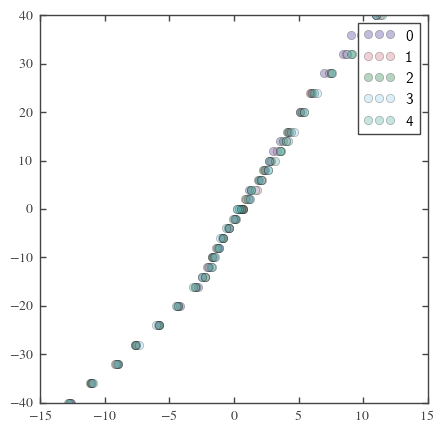

In [13]:
# directory containing base directories for simulations with different electrode surface charges
base_path = '/data/Julia/AuBmimPF6/Experiments/A3/BMImPF6/450/a'

# surface charges to analyze
surf_chgs = [dirs for dirs in os.listdir(base_path) 
              if os.path.isdir(os.path.join(base_path, dirs)) and '.' in dirs]
surf_chgs = sorted(surf_chgs, key=float)


replicas = ['0','1','2','3','4']              # which replicas to analyze for each charge
for r in replicas:
    chg_name='charge.xvg'                   # the name of text file containign values of charge depending on z
    generic_data_path = base_path + '/{surf_chg}'  # should reflect directory structure
    # optional
    pot_name = 'potential_mod.xvg'              # the name of text file containign values of potential depending on z
    field_name = 'field_mod.xvg'                # the name of text file containign values of field depending on z
    walls=None
    #A2 0.551 17.225 0.072
    #A3 0.825 17.499 0.072
    walls = (0.825, 17.499)         #0.072 is a half space between Au-Au layers
    set_chg = False  # x-y dimensions in nm
    debug = True  # extra printing and plotting
    if debug:
        log.setLevel(level=logging.DEBUG)

    simulations = []
    for surf_chg in surf_chgs:
        p = generic_data_path.format(surf_chg=surf_chg)
        try:
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=r, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, set_chg=set_chg)
            simulations.append(chsim)

            #print surf_chg
            #chsim.plot()
        except IOError:
            log.info('Simulations for surf_chg = {} were not found!, skipping!'.format(surf_chg))
        except Exception as e:
            log.exception(e)
            chsim = ChgSimulation(p, chg_name=chg_name, replicas=replicas, field_name=field_name, 
                                  pot_name=pot_name, walls=walls, log=log)
    pots0 = compute_potentials(simulations, exclude_outliers=True)
    #pots1 = compute_potentials(simulations, -.1)
    #pots2 = compute_potentials(simulations, .1)
    plt.plot(pots0[:,0], pots0[:,1],'o', alpha=.3, label=r)
plt.legend()


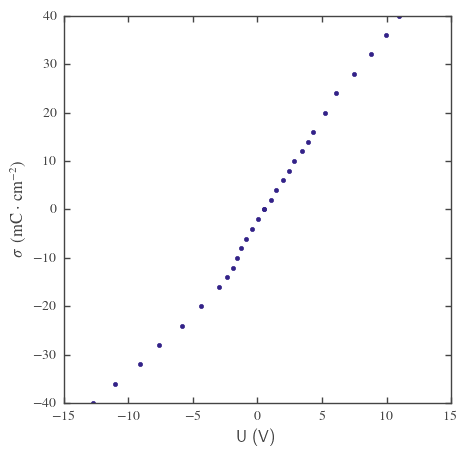

In [7]:
log.setLevel(logging.INFO)

pots0 = compute_potentials(simulations, exclude_outliers=True)
#pots1 = compute_potentials(simulations, -.1)
#pots2 = compute_potentials(simulations, .1)

plt.plot(pots0[:,0], pots0[:,1],'.')
#plt.plot(pots1[:,0], pots1[:,1],'o')
#plt.plot(pots2[:,0], pots2[:,1],'o')
plt.xlabel('U (V)')
plt.ylabel(r'$\sigma$ $(\mathrm{mC\cdot cm^{-2}})$')
